# Bereinigung der einzelnen Datensätze

## Importieren der Datensätze und Pythonmodule

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

df_besucher = pd.read_csv('data/besucher.csv', decimal = ',', sep = ";")   
df_kunden = pd.read_csv('data/kunden.csv', decimal = '.', sep = ";")
df_geo = pd.read_csv('data/geo.txt', decimal = '.', delimiter = "\t")

### Bereinigung von df_geo

In [2]:
df_geo['Niederlassung'].value_counts()

Niederlassung
Baden-Württemberg        382
Bayern                   338
Nordrhein-Westfalen      322
Berlin                   230
Niedersachsen            169
Hessen                   165
Sachsen                  162
Thüringen                 89
Hamburg                   67
Brandenburg               60
NRW                        3
Düsseldorf                 2
Berlin-Charlottenburg      2
Berlin-Mitte               2
BERLIN                     2
Name: count, dtype: int64

In [3]:
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'NRW':'Nordrhein-Westfalen'})
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'Düsseldorf':'Nordrhein-Westfalen'})
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'Berlin-Charlottenburg':'Berlin'})
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'Berlin-Mitte':'Berlin'})
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'BERLIN':'Berlin'})
df_geo['Niederlassung'].value_counts()

Niederlassung
Baden-Württemberg      382
Bayern                 338
Nordrhein-Westfalen    327
Berlin                 236
Niedersachsen          169
Hessen                 165
Sachsen                162
Thüringen               89
Hamburg                 67
Brandenburg             60
Name: count, dtype: int64

### Bereinigung df_besucher (benötigt keine Bereinigung)

In [4]:
df_besucher.isnull().sum() #keine fehlenden Werte

Alter         0
Einkommen     0
Geschlecht    0
Zeit          0
KundeNr       0
dtype: int64

In [5]:
print(df_besucher[(29 >= df_besucher['Alter']) | (df_besucher['Alter'] >= 71)]) #keine unrealistischen Ausreißer
print(df_besucher[(1000 >= df_besucher['Einkommen']) | (df_besucher['Einkommen'] >= 200000)]) #keine unrealistischen Ausreißer
print(df_besucher[(1 >= df_besucher['Zeit']) | (df_besucher['Zeit'] >= 80)]) #keine unrealistischen Ausreißer

Empty DataFrame
Columns: [Alter, Einkommen, Geschlecht, Zeit, KundeNr]
Index: []
Empty DataFrame
Columns: [Alter, Einkommen, Geschlecht, Zeit, KundeNr]
Index: []
Empty DataFrame
Columns: [Alter, Einkommen, Geschlecht, Zeit, KundeNr]
Index: []


### Bereinigung df_kunden

In [6]:
df_kunden.isnull().sum()

Alter         0
Einkommen     0
Preis         0
Geschlecht    5
Zeit          0
KundeNr       0
dtype: int64

In [7]:
geschlecht_modus = df_kunden['Geschlecht'].mode()[0]
df_kunden['Geschlecht'] = df_kunden['Geschlecht'].fillna(geschlecht_modus)
df_kunden.isnull().sum()

Alter         0
Einkommen     0
Preis         0
Geschlecht    0
Zeit          0
KundeNr       0
dtype: int64

In [8]:
print(df_kunden[(29 >= df_kunden['Alter']) | (df_kunden['Alter'] >= 71)]) #braucht korrektur
print(df_kunden[(1000 >= df_kunden['Einkommen']) | (df_kunden['Einkommen'] >= 200000)]) #braucht korrektur
print(df_kunden[(1 >= df_kunden['Zeit']) | (df_kunden['Zeit'] >= 80)]) #braucht keine korrektur

     Alter  Einkommen      Preis  Geschlecht  Zeit KundeNr
142    100    88749.0  119134.23         0.0  64.0   K0494
711    120    61857.0  104214.07         1.0  52.0   K0039
      Alter     Einkommen      Preis  Geschlecht  Zeit KundeNr
408      68  1.000000e+09   87209.72         0.0  52.0   K0701
966      69  0.000000e+00  125140.05         1.0  65.0   K1021
1082     59 -6.284037e+04   92837.59         0.0  46.0   K1083
     Alter  Einkommen      Preis  Geschlecht  Zeit KundeNr
313     62    96569.0  140745.65         0.0  80.0   K0249


In [9]:
Q1_e = df_kunden['Einkommen'].quantile(0.25)
Q3_e = df_kunden['Einkommen'].quantile(0.75)
IQR_e = Q3_e - Q1_e
untere_grenze_e  = Q1_e - 1.5 * IQR_e
obere_grenze_e = Q3_e + 1.5 * IQR_e
df_kunden['Ausreißer'] = (df_kunden['Einkommen'] < untere_grenze_e) | (df_kunden['Einkommen'] > obere_grenze_e).drop(834) #mit ca 107.689€ kein unrealistisches Einkommen
df_kunden['Einkommen'].replace(list(df_kunden.loc[df_kunden['Ausreißer'] == True]['Einkommen']), df_kunden['Einkommen'].median(), inplace = True)
df_kunden = df_kunden.drop('Ausreißer', axis = 1)

In [10]:
Q1_a = df_kunden['Alter'].quantile(0.25)
Q3_a = df_kunden['Alter'].quantile(0.75)
IQR_a = Q3_a - Q1_a
untere_grenze_a  = Q1_a - 1.5 * IQR_a
obere_grenze_a = Q3_a + 1.5 * IQR_a
df_kunden['Ausreißer'] = (df_kunden['Alter'] < untere_grenze_a) | (df_kunden['Alter'] > obere_grenze_a)
df_kunden["Alter"].replace(list(df_kunden.loc[df_kunden["Ausreißer"] == True]["Alter"]), df_kunden["Alter"].median(), inplace = True)
df_kunden = df_kunden.drop("Ausreißer", axis = 1)

In [11]:
print(df_kunden[(29 >= df_kunden['Alter']) | (df_kunden['Alter'] >= 71)]) #korrigiert
print(df_kunden[(1000 >= df_kunden['Einkommen']) | (df_kunden['Einkommen'] >= 200000)]) #korrigiert

Empty DataFrame
Columns: [Alter, Einkommen, Preis, Geschlecht, Zeit, KundeNr]
Index: []
Empty DataFrame
Columns: [Alter, Einkommen, Preis, Geschlecht, Zeit, KundeNr]
Index: []


### Zusammenführung von besucher.csv und kunden.csv

In [12]:
df_alle_ohneGEO = pd.concat([df_besucher,df_kunden], ignore_index=True,)
df_alle_ohneGEO_sortiert = df_alle_ohneGEO.sort_values(by=['KundeNr'],ascending=True).round(decimals=2)

df_alle_ohneGEO_sortiert

,Alter,Einkommen,Geschlecht,Zeit,KundeNr,Preis
1367,68,89437.00,1.0,62.0,K0001,114481.90
1783,58,65271.00,1.0,44.0,K0002,106258.99
1116,44,48195.00,1.0,29.0,K0003,85705.57
1065,37,48957.00,0.0,36.0,K0004,76412.36
1882,50,56621.00,0.0,40.0,K0005,92898.67
...,...,...,...,...,...,...
18,48,59967.31,1.0,21.0,K1991,NaN
799,67,81521.76,1.0,21.0,K1992,NaN
592,40,41616.57,0.0,48.0,K1993,NaN
72,49,76602.79,1.0,19.0,K1994,NaN


### Zusammenführung von geo.txt und df_alle_ohneGEO

In [13]:
df_final= pd.merge(df_alle_ohneGEO_sortiert,df_geo,on='KundeNr', how='outer').set_index('KundeNr')
df_final

,Alter,Einkommen,Geschlecht,Zeit,Preis,Niederlassung
KundeNr,,,,,,
K0001,68,89437.00,1.0,62.0,114481.90,Sachsen
K0002,58,65271.00,1.0,44.0,106258.99,Nordrhein-Westfalen
K0003,44,48195.00,1.0,29.0,85705.57,Hessen
K0004,37,48957.00,0.0,36.0,76412.36,Bayern
K0005,50,56621.00,0.0,40.0,92898.67,Bayern
...,...,...,...,...,...,...
K1991,48,59967.31,1.0,21.0,NaN,Hessen
K1992,67,81521.76,1.0,21.0,NaN,Baden-Württemberg
K1993,40,41616.57,0.0,48.0,NaN,Nordrhein-Westfalen


### F1 Wie viele Autos wurden verkauft

In [14]:
print("Es wurden insgesamt " +str(len(df_kunden.index))+ " Autos verkauft.")

Es wurden insgesamt 1104 Autos verkauft.


### F2 Höchst-, Mindest- und Durchschnittspreis der verkauften Autos

In [15]:
df_max_preis = df_final['Preis'].max()
df_min_preis = df_final['Preis'].min()
df_mean_preis = df_final['Preis'].mean().round(2)
print(f""" Der maximale Betrag für einen Autokauf betrug {df_max_preis}€.
 Der minimale Betrag für einen Autokauf betrug {df_min_preis}€.
 Der Durchschnittspreis betrug {df_mean_preis}€.""")

 Der maximale Betrag für einen Autokauf betrug 165482.31€.
 Der minimale Betrag für einen Autokauf betrug 21471.65€.
 Der Durchschnittspreis betrug 88975.2€.


### F3

In [16]:
Gesamtumsatz = df_final['Preis'].sum()
print(Gesamtumsatz)

98228619.38


### F4 Wie viele Autos wurden pro Bundesland verkauft?

In [17]:
df_sold = df_final[df_final['Preis'].notnull()]
sales_per_state = df_sold['Niederlassung'].value_counts()
print(sales_per_state)

Niederlassung
Baden-Württemberg      205
Bayern                 188
Nordrhein-Westfalen    175
Berlin                 126
Hessen                  96
Niedersachsen           96
Sachsen                 89
Thüringen               49
Hamburg                 43
Brandenburg             37
Name: count, dtype: int64


### F5 durchschnittlicher Umsatz pro Bundesland

In [18]:
bundesländer = pd.Series(["Baden-Württemberg", "Bayern", "Nordrhein-Westfalen", "Berlin", "Niedersachsen", "Hessen", "Sachsen", "Thüringen", "Hamburg", "Brandenburg"])
mean_rev_bl = []

for i in bundesländer:
    mean_rev_bl.append(f'{df_final.loc[df_final.Niederlassung == i, "Preis"].mean().round(2)}€')

mean_rev_bl_pd = pd.Series(mean_rev_bl)
df_mean_rev_bl = pd.concat([mean_rev_bl_pd], axis = 1).set_index(bundesländer)
df_mean_rev_bl.columns = ['durchschnittlicher Umsatz']
df_mean_rev_bl

,durchschnittlicher Umsatz
Baden-Württemberg,90969.56€
Bayern,89344.31€
Nordrhein-Westfalen,88633.27€
Berlin,89584.98€
Niedersachsen,87963.31€
Hessen,85864.93€
Sachsen,89455.08€
Thüringen,90816.99€
Hamburg,85549.5€
Brandenburg,86673.64€


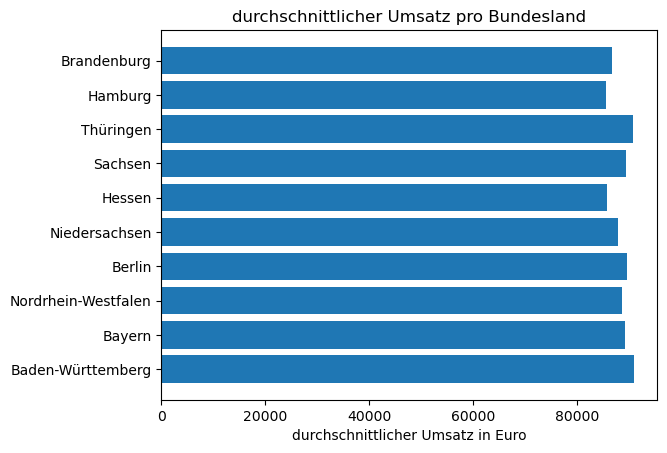

In [19]:
bundesländer = ["Baden-Württemberg", "Bayern", "Nordrhein-Westfalen", "Berlin", "Niedersachsen", "Hessen", "Sachsen", "Thüringen", "Hamburg", "Brandenburg"]
mean_rev_bl = []

for i in bundesländer:
    w = mean_rev_bl.append(df_final.loc[df_final.Niederlassung == i, 'Preis'].mean())

plt.barh(bundesländer, mean_rev_bl)
plt.title ("durchschnittlicher Umsatz pro Bundesland")
plt.xlabel('durchschnittlicher Umsatz in Euro')
plt.show()


### F6

In [20]:
# Finde Index des Kunden mit maximalen Preis
index_MaxPreis = df_final['Preis'].idxmax()
print(df_final.loc[index_MaxPreis]['Niederlassung'])

Niedersachsen


### F8 Durchschnittsalter unserer Kunden/Besucher (UNBEREINIGT)

In [21]:
print(f"""Die Kunden sind durchschnittlich {df_kunden['Alter'].mean().round(2)} Jahre alt.
Die Besucher sind durchschnittlich {df_besucher['Alter'].mean().round(2)} Jahre alt.""")

Die Kunden sind durchschnittlich 50.38 Jahre alt.
Die Besucher sind durchschnittlich 49.88 Jahre alt.


### F9

In [22]:
print(f"""Die Kunden haben ein durchschniitliches Einkommen von {df_kunden['Einkommen'].mean().round(2)} Euro.
Die Besucher haben ein durchschnittliches Einkommen von {df_besucher['Einkommen'].mean().round(2)} Euro.""")

Die Kunden haben ein durchschniitliches Einkommen von 58895.0 Euro.
Die Besucher haben ein durchschnittliches Einkommen von 59367.94 Euro.


### F10

### F11 Korrelation zwischen Alter, Einkommen, Preis und Zeit

In [23]:
corr_a_e = df_kunden['Alter'].corr(df_kunden['Einkommen']).round(6)
corr_a_p = df_kunden['Alter'].corr(df_kunden['Preis']).round(6)
corr_a_z = df_kunden['Alter'].corr(df_kunden['Zeit']).round(6)
corr_e_p = df_kunden['Einkommen'].corr(df_kunden['Preis']).round(6)
corr_e_z = df_kunden['Einkommen'].corr(df_kunden['Zeit']).round(6)
corr_p_z = df_kunden['Preis'].corr(df_kunden['Zeit']).round(6)   
    
print(f'''
Pearson-Korrelation zwischen Alter und Einkommen:  {corr_a_e} - geringe vernachlässigbare Korrelation
Pearson-Korrelation zwischen Alter und Preis:      {corr_a_p} - hohe Korrelation
Pearson-Korrelation zwischen Alter und Zeit:       {corr_a_z}   - mittlere Korrelation
Pearson-Korrelation zwischen Einkommen und Preis: {corr_e_p} - geringe vernachlässigbare Korrelation
Pearson-Korrelation zwischen Einkommen und Zeit:   {corr_e_z} - geringe vernachlässigbare Korrelation
Pearson-Korrelation zwischen Preis und Zeit:       {corr_p_z} - hohe Korrelation''')


Pearson-Korrelation zwischen Alter und Einkommen:  0.761553 - geringe vernachlässigbare Korrelation
Pearson-Korrelation zwischen Alter und Preis:      0.780478 - hohe Korrelation
Pearson-Korrelation zwischen Alter und Zeit:       0.588912   - mittlere Korrelation
Pearson-Korrelation zwischen Einkommen und Preis: 0.896557 - geringe vernachlässigbare Korrelation
Pearson-Korrelation zwischen Einkommen und Zeit:   0.776198 - geringe vernachlässigbare Korrelation
Pearson-Korrelation zwischen Preis und Zeit:       0.707778 - hohe Korrelation


### F12

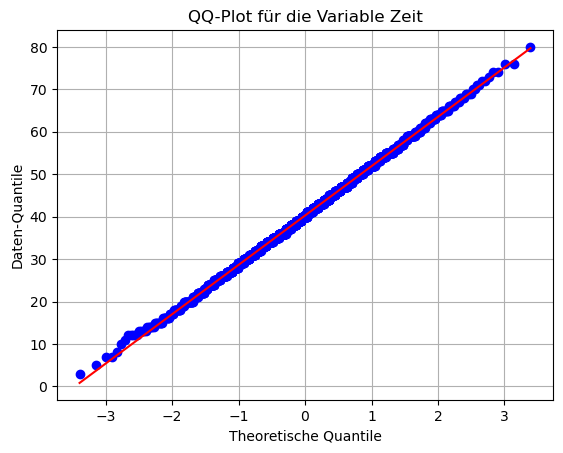

In [24]:
stats.probplot(df_final['Zeit'], dist="norm", plot=plt)
plt.title('QQ-Plot für die Variable Zeit')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Daten-Quantile')
plt.grid(True)
plt.show()

### F13

In [25]:
print("Die Anzahl der Kunden, die einen Kredit aufnehmen mussten ist " + str(sum((df_kunden['Preis'] >= df_kunden['Einkommen'])))+".")

Die Anzahl der Kunden, die einen Kredit aufnehmen mussten ist 1099.


### F14 Einfluss sozioökonomischer Merkmale auf den Kaufpreis

                            OLS Regression Results                            
Dep. Variable:                  Preis   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1329.
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        01:07:12   Log-Likelihood:                -11748.
No. Observations:                1104   AIC:                         2.351e+04
Df Residuals:                    1099   BIC:                         2.353e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -130.1040   1532.387     -0.085      0.9

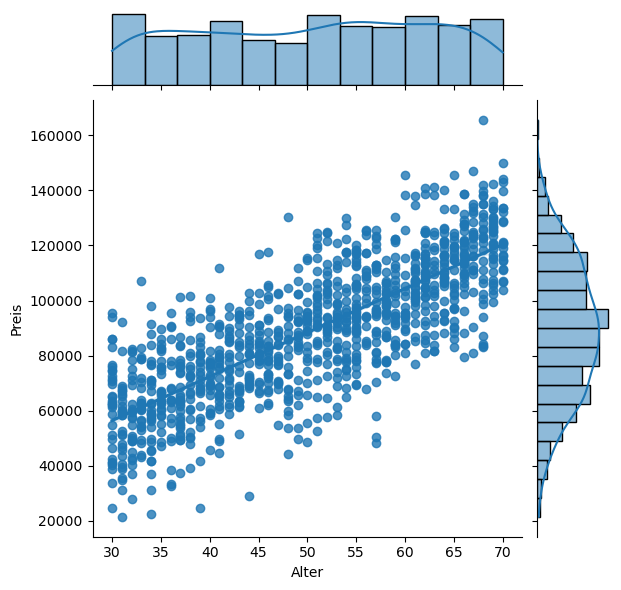

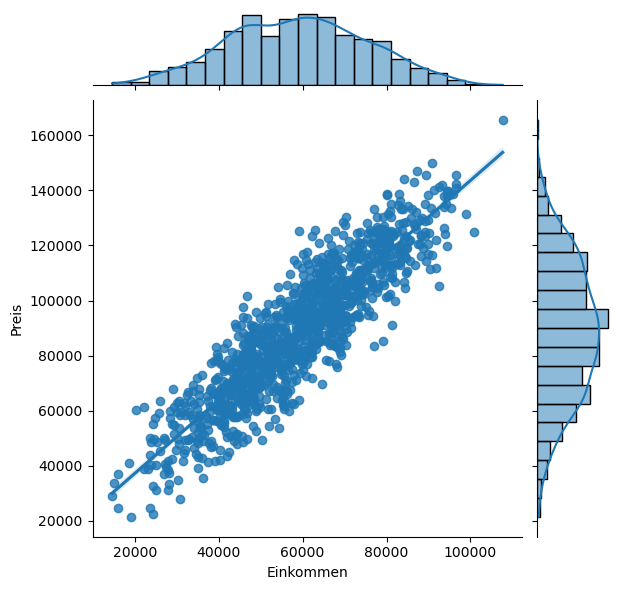

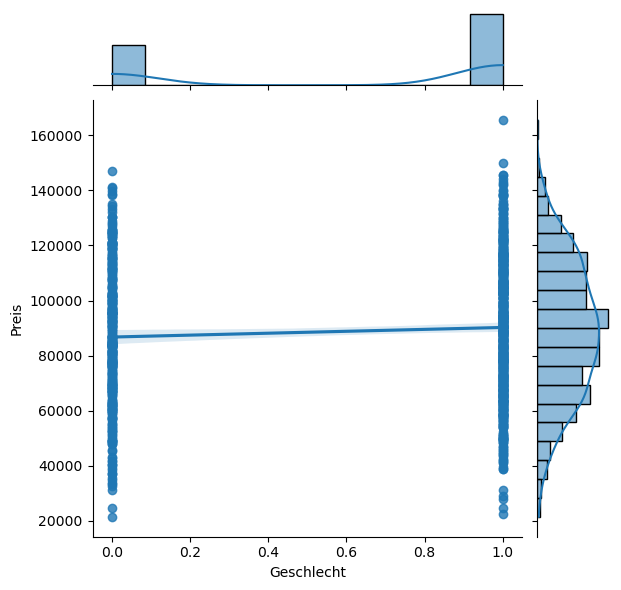

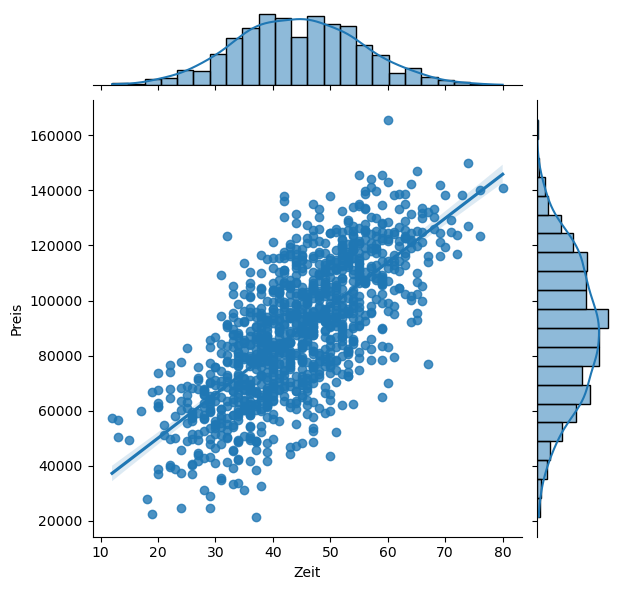

In [26]:
XVar_without_const = df_kunden.drop(["Preis", "KundeNr"], axis = 1)
XVar = sm.add_constant(XVar_without_const)
YVar = df_kunden["Preis"]
linearModel1 = sm.OLS(YVar, XVar).fit()
print(linearModel1.summary())
print(sns.jointplot(x = df_kunden["Alter"], y = df_kunden["Preis"], kind = "reg"))
print(sns.jointplot(x = df_kunden["Einkommen"], y = df_kunden["Preis"], kind = "reg"))
print(sns.jointplot(x = df_kunden["Geschlecht"], y = df_kunden["Preis"], kind = "reg"))
print(sns.jointplot(x = df_kunden["Zeit"], y = df_kunden["Preis"], kind ="reg"))

### F17 Wahrscheinlichkeit des Kaufs eines Autos

In [27]:
df_final["Kauf"] = (df_final["Preis"] / df_final["Preis"]).fillna(0)

X_log_reg = df_final.drop(["Kauf", "Niederlassung", "Preis"], axis = 1)
Y_log_reg = df_final["Kauf"]

X_train, X_test, y_train, y_test = train_test_split(X_log_reg, Y_log_reg, test_size = 0.3, random_state = 21)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LogReg = LogisticRegression(random_state = 0).fit(X_train_scaled, y_train)

In [28]:
LogReg.score(X_train_scaled, y_train)

0.7113180515759312

In [29]:
LogReg.score(X_test_scaled, y_test)

0.7362270450751253

### F18 Wahrscheinlichkeit des Kaufs eines Autos

In [32]:
LogReg.predict(np.array([[32, 30.000, 1.0, 30]]))[0]

1.0

In [33]:
LogReg.predict(np.array([[51, 54.000, 1.0, 45]]))[0]

1.0

# Datei speichern

In [31]:
#df_final.to_csv('.\data\df_final.csv')